In [1]:
#!g1.1
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math

In [2]:
#!g1.1
mnist_transforms = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.2MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.08MB/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
#!g1.1
def train(model):
    model.train()

    train_loss = 0

    for x, _ in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [4]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x, _ in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)

        loss = loss_fn(output, x)

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [5]:
#!g1.1
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
#!g1.1
from torchvision.utils import make_grid


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()

    plt.figure(figsize=(20, 4))

    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )

    plt.axis('off')

    plt.show()

In [7]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [42]:
#!g1.1
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )
        self.encoder = nn.Sequential(*encoder_blocks)

        self.embedding_layer = nn.Linear(512, 128)
        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

    @torch.inference_mode()
    def embed(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.flatten(self.encoder(x))
        embedding = self.embedding_layer(x)  # Преобразуем в эмбеддинг длиной 128
        return embedding

In [43]:
#!g1.1
class DenoisingBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        if self.training:
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.norm(self.conv(x)))


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = DenoisingBlock, base_size: int = 32, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1)

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

In [44]:
#!g1.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

model = DenoisingAutoEncoder(in_channels=1).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()

cuda


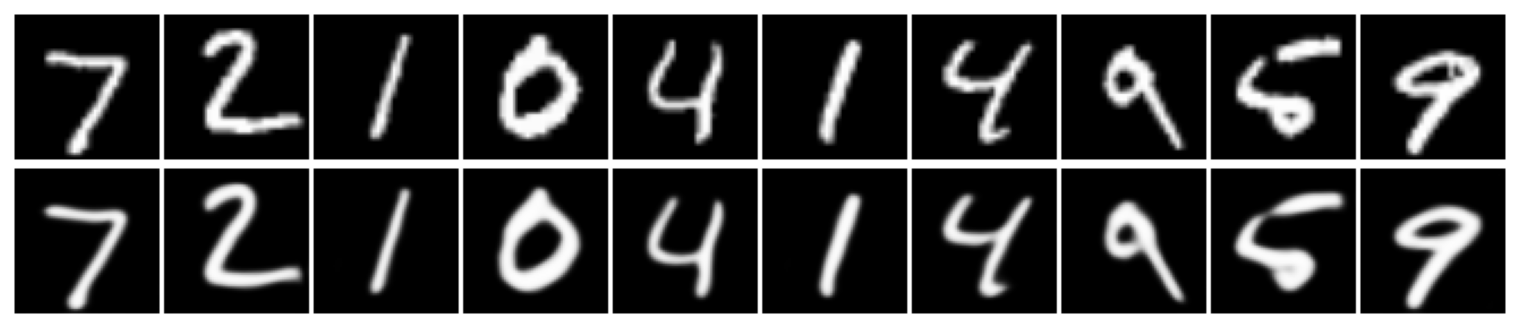

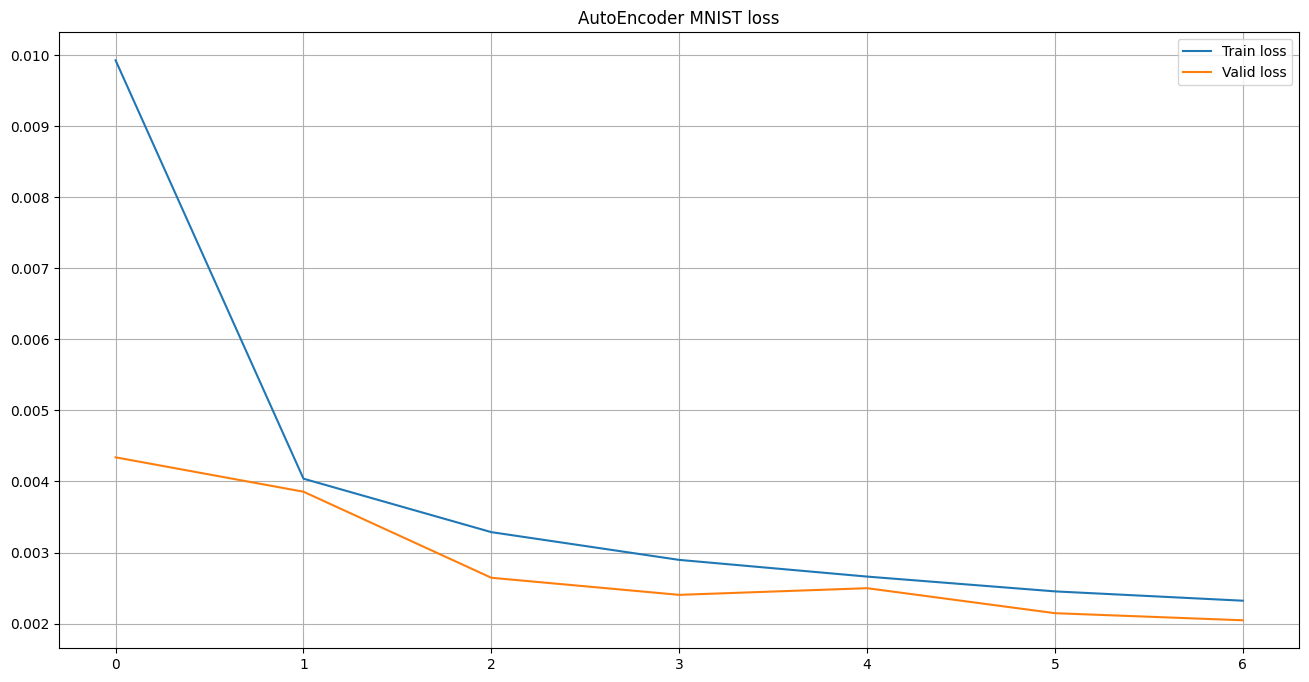

In [45]:
whole_train_valid_cycle(model, 7, 'AutoEncoder MNIST')

In [55]:
@torch.inference_mode()
def get_latent_labels(model, loader, count: int=None):
    model.eval()

    total = 0

    latent = []
    labels = []

    for x, y in loader:
        z = model.embed(x.to(device)).cpu()

        latent.append(z)
        labels.append(y)

        total += y.shape[0]

        if count is not None and total >= count:
            break

    latent = torch.cat(latent)[:count].numpy()
    labels = torch.cat(labels)[:count].numpy()

    return latent, labels

In [47]:
x_train, y_train = get_latent_labels(model, train_loader, 1000)

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


In [48]:
x_train.shape, y_train.shape

((1000, 128), (1000,))

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [60]:
scaler = StandardScaler()
x_valid, y_valid = get_latent_labels(model, valid_loader)
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

clf = RandomForestClassifier().fit(x_train, y_train)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [61]:
accuracy_score(y_valid, clf.predict(x_valid))

0.9007

In [ ]:
# сделал дело гуляй смело!